In [1]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
import shutil
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms


from torch import Generator
from torch.utils.data import Dataset, DataLoader, Subset, random_split, SubsetRandomSampler
from sklearn.model_selection import train_test_split

In [60]:
base_path = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Pandora_18k_Merged\\"

folders = [ f.path for f in os.scandir(base_path) if f.is_dir() ]
classes_names = [ f.name for f in os.scandir(base_path) if f.is_dir() ]
classes = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18"]

class_mapping = {
    "01_Byzantin_Iconography": 0,
    "02_Early_Renaissance":1,
    "03_Northern_Renaissance":2,
    "04_High_Renaissance":3,
    "05_Baroque":4,
    "06_Rococo":5,
    "07_Romanticism":6,
    "08_Realism":7,
    "09_Impressionism":8,
    "10_Post_Impressionism":9,
    "11_Expressionism":10,
    "12_Symbolism":11,
    "13_Fauvism":12,
    "14_Cubism":13,
    "15_Surrealism":14,
    "16_AbstractArt":15,
    "17_NaiveArt":16,
    "18_PopArt" : 17
}

image_path_by_class = []
aux_str = []

for folder in folders:
    aux_str = folder + "//" + "*.jpg"
    image_path_by_class.append(glob.glob(aux_str))
print(classes_names)

['01_Byzantin_Iconography', '02_Early_Renaissance', '03_Northern_Renaissance', '04_High_Renaissance', '05_Baroque', '06_Rococo', '07_Romanticism', '08_Realism', '09_Impressionism', '10_Post_Impressionism', '11_Expressionism', '12_Symbolism', '13_Fauvism', '14_Cubism', '15_Surrealism', '16_AbstractArt', '17_NaiveArt', '18_PopArt']


In [48]:
labels = []
for index, class_path in enumerate(image_path_by_class):
  tmp = []
  for img_path in class_path:
    label = img_path.split("\\")[6]
    tmp.append(label)
  labels.append(tmp)

# labels=np.array(labels)
# print(labels)
print(len(labels[2]))
print(len(image_path_by_class[2]))

# len(labels)
targets = []
for label in labels:
    tmp = []
    for img_label in label:
      tmp.append(img_label)
    targets.append(tmp)


print(len(targets[2]))


802
802
802


16_AbstractArt


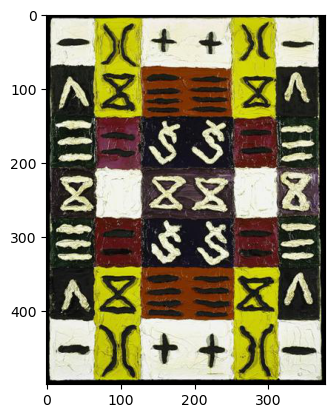

In [9]:
class_name = 15
picture = 200

test_img = cv2.imread(image_path_by_class[class_name][picture])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(test_img)

print(labels[class_name][picture])

## Split into Train and Test

The result will be
1. a list: `train_data` that will contain the paths to the images
2. a list: `train_data_labels` the will contain the labels of the images

the split will be 80% train and 20% test, but the proportions can be changed in `train_test_split` method

In [11]:
data = image_path_by_class
data = []
labels_merged = []
for class_index in range(len(image_path_by_class)):
    for img_index in range(len(image_path_by_class[class_index])):
        data.append(image_path_by_class[class_index][img_index])

for class_index in range(len(labels)):
    for img_index in range(len(labels[class_index])):
        labels_merged.append(labels[class_index][img_index])

print(len(data))

train_data0, test_data0 = random_split(data, [0.7, 0.3], generator=Generator().manual_seed(42))

train_data, test_data, train_labels, test_labels = train_test_split(
    data,
    labels_merged,
    test_size=0.2,
    random_state=42
)
print("Test and Train:")
print(len(train_data))
print(len(test_data))
print("Test and Train Labels:")
print(len(train_labels))
print(len(test_labels))


17591
Test and Train:
14072
3519
Test and Train Labels:
14072
3519


18_PopArt


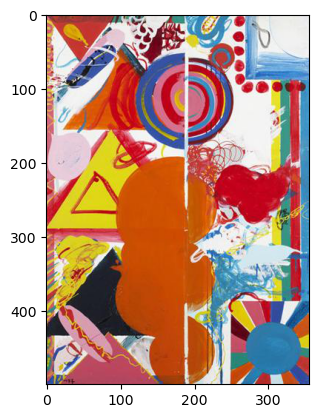

In [13]:
picture = 1200

test_img = cv2.imread(train_data[picture])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(test_img)

print(train_labels[picture])

## Define the Dataset

In [68]:
class DatasetPandora(Dataset):
    def __init__(self, image_paths, labels):
        
        self.data = image_paths
        self.labels = labels
        self.targets = []

        for label in labels:
            self.targets.append(class_mapping[label])

        self.transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):

        img = cv2.imread(self.data[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = np.transpose(img, [2,0,1])

        batch_data = img
        batch_data = self.transf(batch_data)
        batch_targets = self.targets[idx]

        batch_labels = self.labels[idx]

        batch = {'data': batch_data, 'labels': batch_labels, 'targets': batch_targets}

        return batch

train_data_dataset = DatasetPandora(train_data, train_labels)
train_loader = DataLoader(train_data_dataset, batch_size=128, shuffle=True, num_workers=0)

# test_data_dataset = DatasetPandora(test_data, train_labels)
# test_loader = DataLoader(test_data_dataset, batch_size=128)


# for batch in train_loader:
#     # plt.figure()
#     # plt.imshow(batch["data"][0])
#     print(batch["data"][0])
#     print(batch["label"][0])
#     break



# Define the network

In [67]:
class Retea_CNN(nn.Module):
    
    def __init__(self, nr_clase):
        
        # Pentru a putea folosi mai departe reteaua, este recomandata mostenirea
        # clasei de baza nn.Module
        super(Retea_CNN,self).__init__()
        
        # 3, 224, 224
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=[3, 3], stride = [1, 1], padding = [1, 1])
        self.relu1 = nn.ReLU()
        # 6, 224, 224
        self.maxpool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2])

        # 6, 112, 112
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=[3, 3], stride = [1, 1], padding = [1, 1])
        self.relu2 = nn.ReLU()
        # 9, 112, 112
        self.maxpool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2])

        # 9, 56, 56
        self.fc1 = nn.Linear(in_features=56*56*9, out_features=256)
        self.relu3 = nn.ReLU()
        self.out = nn.Linear(in_features=256, out_features=nr_clase)
    
    def forward(self,input_batch):

        x = self.conv1(input_batch)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = torch.flatten(x, 1, 3)
        x = self.fc1(x)
        x = self.relu3(x)
        out = self.out(x)
        
        return out
    

In [66]:
# Instantiem reteaua
cnn = Retea_CNN(18)

# Specificarea functiei loss
loss_function = nn.CrossEntropyLoss(reduction='sum')

# Specificarea optimizatorului
optim = torch.optim.Adam(cnn.parameters(), lr=1e-5)

# Definim dataset
train_data_dataset = DatasetPandora(train_data, train_labels)
train_loader = DataLoader(train_data_dataset, batch_size=128, shuffle=True, num_workers=0)

nr_epoci = 15

for ep in range(nr_epoci):
    predictii = []
    etichete = []

    for batch in train_loader:
        batch_data = batch['data']
        batch_labels = batch['labels']
        batch_targets = batch['targets']
        # Se calculeaza predictia retelei pentru datele curente (forward pass/ propagare inainte)
        current_predict = cnn.forward(batch_data)

        # Se calculeaza valoarea momentana a functiei loss
        loss = loss_function(current_predict, batch_targets) 
        
        # Se memoreaza predictiile si etichetele aferente batch-ului actual (pentru calculul acuratetii)
        current_predict = np.argmax(current_predict.detach().numpy(), axis=1)
        predictii = np.concatenate((predictii,current_predict))
        etichete = np.concatenate((etichete,batch_labels))
        
        # Antrenarea propriu-zisa
        
            # 1. Se sterg toti gradientii calculati anteriori, pentru toate variabilele antrenabile
            # deoarece, metoda <backward> acumuleaza noile valori, in loc sa le inlocuiasca.
        optim.zero_grad()
            # 2. Calculul tuturor gradientilor. Backpropagation
        loss.backward()
            # 3. Actualizarea tuturor ponderilor, pe baza gradientilor.
        optim.step()
    
    # Calculam acuratetea
    acc = np.sum(predictii==etichete)/len(predictii)
    print( 'Acuratetea la epoca {} este {}%'.format(ep+1,acc*100) )

C:\Users\Teodora\AppData\Local\Temp\ipykernel_12940\393912488.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  acc = np.sum(predictii==etichete)/len(predictii)


Acuratetea la epoca 1 este 0.0%
Acuratetea la epoca 2 este 0.0%
Acuratetea la epoca 3 este 0.0%
Acuratetea la epoca 4 este 0.0%
Acuratetea la epoca 5 este 0.0%
Acuratetea la epoca 6 este 0.0%
Acuratetea la epoca 7 este 0.0%
Acuratetea la epoca 8 este 0.0%
Acuratetea la epoca 9 este 0.0%
Acuratetea la epoca 10 este 0.0%
Acuratetea la epoca 11 este 0.0%
Acuratetea la epoca 12 este 0.0%
Acuratetea la epoca 13 este 0.0%
Acuratetea la epoca 14 este 0.0%
Acuratetea la epoca 15 este 0.0%


# MobileNet

In [70]:
mobile_net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
print(mobile_net)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Using cache found in C:\Users\Teodora/.cache\torch\hub\pytorch_vision_v0.10.0


In [71]:
mobile_net.classifier[1] = nn.Linear(in_features=1280, out_features=18, bias=True)
 

# Specificarea functiei loss
loss_function = nn.CrossEntropyLoss(reduction='sum')

# Specificarea optimizatorului
optim = torch.optim.Adam(mobile_net.parameters(), lr=1e-5)

# Definim dataset
train_data_dataset = DatasetPandora(train_data, train_labels)
train_loader = DataLoader(train_data_dataset, batch_size=128, shuffle=True, num_workers=0)

nr_epoci = 10
mobile_net.train()
for ep in range(nr_epoci):
    predictii = []
    etichete = []

    for batch in train_loader:
        batch_data = batch['data']
        batch_labels = batch['labels']
        batch_targets = batch['targets']
        # Se calculeaza predictia retelei pentru datele curente (forward pass/ propagare inainte)
        current_predict = mobile_net.forward(batch_data)

        # Se calculeaza valoarea momentana a functiei loss
        loss = loss_function(current_predict, batch_targets) 
        
        # Se memoreaza predictiile si etichetele aferente batch-ului actual (pentru calculul acuratetii)
        current_predict = np.argmax(current_predict.detach().numpy(), axis=1)
        predictii = np.concatenate((predictii,current_predict))
        etichete = np.concatenate((etichete,batch_labels))
        
        # Antrenarea propriu-zisa
        
            # 1. Se sterg toti gradientii calculati anteriori, pentru toate variabilele antrenabile
            # deoarece, metoda <backward> acumuleaza noile valori, in loc sa le inlocuiasca.
        optim.zero_grad()
            # 2. Calculul tuturor gradientilor. Backpropagation
        loss.backward()
            # 3. Actualizarea tuturor ponderilor, pe baza gradientilor.
        optim.step()
    
    # Calculam acuratetea
    acc = np.sum(predictii==etichete)/len(predictii)
    print( 'Acuratetea la epoca {} este {}%'.format(ep+1,acc*100) )

KeyboardInterrupt: 